# Use hh2 dataset to train a maching learning model

In [1]:
# Data Management/Investigation
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn import tree # For plotting the decision tree rules
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# For model interpretation
from sklearn.inspection import (
    permutation_importance,
    partial_dependence, 
    PartialDependenceDisplay, 
    plot_partial_dependence
)

# Misc
import warnings
warnings.filterwarnings("ignore")

Import Dataset and remove variables where outcome is a nonstarter

In [2]:
hh = pd.read_csv("/Users/xavier/Desktop/DSPP/DS/Data-Science-1-Final-Project/Data_Wrangling/hh3.csv")

In [3]:
hh.shape

(70203, 19)

In [4]:
hh = hh[hh.unbanked >= 0]

In [5]:
hh = hh.dropna()

In [6]:
hh.shape

(32261, 19)

In [7]:
hh_bin = hh[["unbanked","poverty","under_25","unemployed","citizen","native_born","White_or_AAPI","inc_vol","internet","children","single_mother"]]

Split the data by X and Y and prepare training sample

In [8]:
y = hh["unbanked"]
X = hh[["poverty","under_25","unemployed","citizen","native_born","White_or_AAPI","inc_vol","internet","children","single_mother"]]

In [9]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.1,random_state=1999)

In [10]:
# Let's 
scaler = pp.MinMaxScaler()
col_names = list(train_X)
train_X = scaler.fit_transform(train_X)

In [11]:
# Convert back into data frame
train_X = pd.DataFrame(train_X,columns=col_names)
train_X

,poverty,under_25,unemployed,citizen,native_born,White_or_AAPI,inc_vol,internet,children,single_mother
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
29029,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
29030,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
29031,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
29032,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [12]:
# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ["poverty","under_25","unemployed","citizen","native_born","White_or_AAPI","inc_vol","internet","children","single_mother"])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['poverty',
                                                                          'under_25',
                                                                          'unemployed',
                                                                          'citizen',
                                                                          'native_born',
                                                                          'White_or_AAPI',
                                                                          'inc_vol',
                                                                          'internet',
              

In [13]:
search.best_score_

-0.038312774819089276

In [14]:
search.best_params_

{'model': DecisionTreeRegressor(max_depth=5), 'model__max_depth': 5}

In [15]:
pred_y = search.predict(test_X)

In [16]:
#the best model is a random forest so we need to establish it as a variable
dtree = search.best_estimator_

In [17]:
m.mean_squared_error(test_y,pred_y)

0.049242810561918544

In [18]:
m.r2_score(test_y,pred_y)

-0.05751561310954556

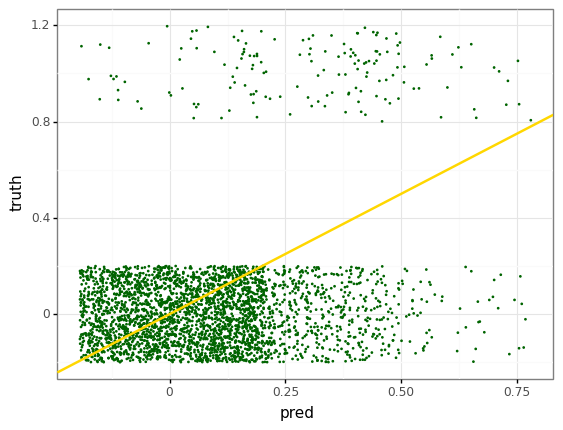

<ggplot: (8789242825241)>

In [19]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_jitter(color="darkgreen", size=.1, width = 0.2, height = 0.2) +
    geom_abline(color="gold",size=1) +
    theme_bw() 
)

In [20]:
#permute features to determine importances
vi = permutation_importance(dtree,train_X,train_y,n_repeats=25)

In [21]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,poverty,0.092758,0.003066,0.086625,0.098890
1,internet,0.089382,0.003024,0.083333,0.095430
2,White_or_AAPI,0.060975,0.003617,0.053741,0.068210
3,children,0.018191,0.001942,0.014306,0.022076
4,inc_vol,0.013324,0.001688,0.009947,0.016700
5,citizen,0.008399,0.000936,0.006527,0.010271
6,under_25,0.005237,0.000895,0.003448,0.007026
7,single_mother,0.004501,0.000517,0.003467,0.005535
8,native_born,0.002407,0.000777,0.000853,0.003962
9,unemployed,0.002353,0.000601,0.001151,0.003556


In [24]:
vi_dat.to_csv("/Users/xavier/Desktop/DSPP/DS/Data-Science-1-Final-Project/Submission_Content/Fig_Data/Rev_Bin_Sel_Var_Reliance.csv")

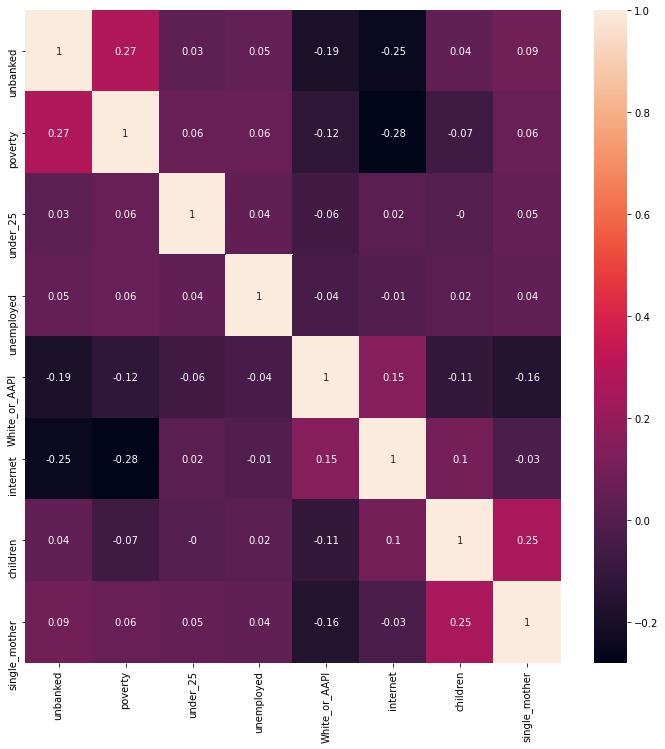

In [23]:
import seaborn as sns 
correlation_mat = hh_bin.corr()
correlation_mat = correlation_mat.round(decimals = 2)
plt.figure(figsize = (12,12))
sns.heatmap(correlation_mat, annot = True)
plt.show()